# Compute SNR for galactic binaries

### Imports and constants

In [24]:
from gbgpu import gbgpu
import pandas as pd
import numpy as np
from copy import copy
from eryn.backends import HDFBackend

# useful imports
from lisatools.sensitivity import LISASens, get_sensitivity, get_stock_sensitivity_options
from lisatools.sensitivity import SensitivityMatrix, LISASens, A1TDISens, E1TDISens
import lisatools.detector as lisa_models
import matplotlib.pyplot as plt

from lisatools.utils.constants import YRSID_SI
from tqdm import tqdm
import glob
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.sensitivity import SensitivityMatrix
from lisatools.sensitivity import XYZ1SensitivityMatrix

from project_catalog.utils import get_galactic_binary_names
from project_catalog.galactic_binary import GalacticBinary
from lisatools.sensitivity import X1TDISens
from lisatools.sensitivity import AE1SensitivityMatrix
from lisatools.stochastic import HyperbolicTangentGalacticForeground

from lisatools.sensitivity import *

YEAR = 525600 * 60

In [23]:
def get_params(params_dict):
    amp = params_dict['Amplitude']
    f0 = params_dict['Frequency']
    fdot = params_dict['Frequency Derivative']
    fddot = 0.0
    phi0 = params_dict['Initial Phase']
    iota = params_dict['Inclination']
    psi = params_dict['Polarization']
    lam = params_dict['Ecliptic Longitude']
    beta = params_dict['Ecliptic Latitude']

    params = np.array([amp, f0, fdot, fddot, phi0, iota, psi, lam, beta])
    return params

In [2]:
inj_df = pd.read_feather('../../data/injection_set/sangria_ucb_params.feather')

In [ ]:
# Tyson's PSD
# df = pd.read_feather('/Users/aaron/Documents/lisa/project-catalog/data/old/noise_psds/psd_xyz.feather')

### Get PSD from Eryn chain

In [3]:
# Make frequency array
time = np.arange(0, YRSID_SI, 5.0)
freq = np.fft.rfftfreq(len(time), d=5.0)

In [4]:
hbackend = HDFBackend('/Users/aaron/Documents/lisa/project-catalog/data/erebor_training_catalogs_v1.0.4/erebor_training_catalogs_v1.0.4_parameter_estimation_psd.h5')
chain = hbackend.get_chain(temp_index=0)

In [ ]:
s_oms, s_acc = chain['psd'][-1, 0, 0][:2]
galactic_foreground_params = chain['galfor'][-1, 0, 0]
amplitude, alpha, s1, knee_f, s2 = galactic_foreground_params

model = copy(lisa_models.sangria)
model.Soms_d = s_oms**2
model.Sa_a = s_acc**2

In [22]:
Sn_A = A1TDISens.get_Sn(freq,
                      stochastic_params=(amplitude, knee_f, alpha, s1, s2),
                      stochastic_function=HyperbolicTangentGalacticForeground,
                      model=model)

Sn_E = E1TDISens.get_Sn(freq,
                      stochastic_params=(amplitude, knee_f, alpha, s1, s2),
                      stochastic_function=HyperbolicTangentGalacticForeground,
                      model=model)

ae_mat = AE1SensitivityMatrix(f=freq)
ae_mat._sens_mat[0] = Sn_A
ae_mat._sens_mat[1] = Sn_E

/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/stochastic.py:178: RuntimeWarning: divide by zero encountered in power
  * (f ** (-7.0 / 3.0))
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/sensitivity.py:382: RuntimeWarning: invalid value encountered in multiply
  return 1.5 * (Sh * t)


In [ ]:
def make_get_snr():
    gb = gbgpu.GBGPU()
    time = np.arange(0, YRSID_SI, 5.0)
    f = np.fft.rfftfreq(len(time), d=5.0)
    data = [np.zeros(len(f)), np.zeros(len(f))]
    Sn_A = A1TDISens.get_Sn(freq,
                      stochastic_params=(amplitude, knee_f, alpha, s1, s2),
                      stochastic_function=HyperbolicTangentGalacticForeground,
                      model=model)
    Sn_E = E1TDISens.get_Sn(freq,
                        stochastic_params=(amplitude, knee_f, alpha, s1, s2),
                        stochastic_function=HyperbolicTangentGalacticForeground,
                        model=model)

    ae_mat = AE1SensitivityMatrix(f=freq)
    ae_mat._sens_mat[0] = Sn_A
    ae_mat._sens_mat[1] = Sn_E
    def get_snr(params_dict):
        # name = params_dict['Name']
        amp = params_dict['Amplitude']
        f0 = params_dict['Frequency']
        fdot = params_dict['Frequency Derivative']
        fddot = 0.0
        phi0 = params_dict['Initial Phase']
        iota = params_dict['Inclination']
        psi = params_dict['Polarization']
        lam = params_dict['Ecliptic Longitude']
        beta = params_dict['Ecliptic Latitude']

        params = np.array([amp, f0, fdot, fddot, phi0, iota, psi, lam, beta])
        gb.d_d = 0.0
        gb.get_ll(params, data, ae_mat)[0]
        return np.sqrt(np.real(gb.h_h))
    return get_snr

In [40]:
get_snr = make_get_snr()

/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_S

In [51]:
snr = []
for i in tqdm(range(len(inj_df))):
    snr.append(get_snr(inj_df.iloc[i]))

100%|██████████| 29000000/29000000 [3:12:03<00:00, 2516.55it/s]  


In [52]:
np.save('./snrs.npy', snr)

In [55]:
snr_2 = np.array([float(snr[i][0]) for i in range(len(snr))])

In [56]:
snr_2

array([0.00655606, 0.0010527 , 0.0042708 , ..., 0.00865608, 0.01896246,
       0.00164712], shape=(29000000,))

In [57]:
inj_df['SNR'] = snr_2

In [59]:
inj_df.to_feather('/Users/aaron/Documents/lisa/project-catalog/data/injection_set/sangria_ucb_params.feather')

In [41]:
pc_df = pd.read_feather('/Users/aaron/Documents/lisa/project-catalog/data/erebor/posterior_chains/LDC2A_00000000.feather')

In [50]:
pc_df.iloc[2]

Group ID                      0.0
Confidence                    1.0
SNR                     16.387731
Amplitude                     0.0
Frequency                0.000433
Frequency Derivative         -0.0
Initial Phase            5.873171
cosinc                  -0.541135
Polarization              0.92818
Ecliptic Longitude       3.893313
sinlat                   0.819105
Ecliptic Latitude         0.95985
coslat                   0.819105
Inclination              2.142582
Parent                       None
Name: 20481, dtype: object

In [49]:
get_snr(pc_df.iloc[2])

array([25.00568904])

In [44]:
def make_get_snr_2():
    gb = gbgpu.GBGPU()
    time = np.arange(0, YRSID_SI, 5.0)
    f = np.fft.rfftfreq(len(time), d=5.0)
    data = [np.zeros(len(f)), np.zeros(len(f))]
    sens_mat3 = AE1SensitivityMatrix(
        f,
        stochastic_params=(1.0 * YRSID_SI,),
        model=lisa_models.sangria,
    )
    def get_snr(params_dict):
        # name = params_dict['Name']
        amp = params_dict['Amplitude']
        f0 = params_dict['Frequency']
        fdot = params_dict['Frequency Derivative']
        fddot = 0.0
        phi0 = params_dict['Initial Phase']
        iota = params_dict['Inclination']
        psi = params_dict['Polarization']
        lam = params_dict['Ecliptic Longitude']
        beta = params_dict['Ecliptic Latitude']

        params = np.array([amp, f0, fdot, fddot, phi0, iota, psi, lam, beta])
        gb.d_d = 0.0
        gb.get_ll(params, data, sens_mat3)[0]
        return np.sqrt(np.real(gb.h_h))
    return get_snr

In [45]:
get_snr_2 = make_get_snr_2()

/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_S

In [46]:
get_snr_2(pc_df.iloc[0])

array([13.42706916])

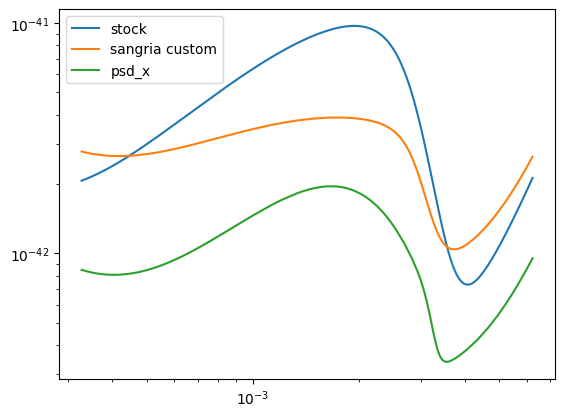

In [ ]:
# sn = X1TDISens.get_Sn(df['Frequency'].to_numpy(), stochastic_params=(amplitude, knee_f, alpha, s1, s2), stochastic_function=HyperbolicTangentGalacticForeground,
#         model=model)
# s_model = X1TDISens.get_Sn(df['Frequency'].to_numpy(), stochastic_params=(1.0 * YRSID_SI,),
#         model=lisa_models.sangria)
# plt.loglog(df['Frequency'], s_model, label='stock')
# plt.loglog(df['Frequency'], sn, label='sangria custom')
# plt.loglog(df['Frequency'], df['SXX'], label='psd_x')
# plt.legend()

In [ ]:
# matrix = [[df['SXX'].to_numpy(), df['SXY'].to_numpy(), df['SZX'].to_numpy()],
#           [df['SXY'].to_numpy(), df['SYY'].to_numpy(), df['SYZ'].to_numpy()],
#           [df['SZX'].to_numpy(), df['SYZ'].to_numpy(), df['SZZ'].to_numpy()]]

In [ ]:
xyz_mat = XYZ1SensitivityMatrix(f = df['Frequency'].to_numpy()[index_array], )
# sens_mat = SensitivityMatrix(f = df['Frequency'].to_numpy(), sens_mat=)

In [102]:
xyz_mat._sens_mat[0, 0, :] = df['SXX'].to_numpy()[index_array]
xyz_mat._sens_mat[0, 1, :] = df['SXY'].to_numpy()[index_array]
xyz_mat._sens_mat[0, 2, :] = df['SZX'].to_numpy()[index_array]
xyz_mat._sens_mat[1, 1, :] = df['SYY'].to_numpy()[index_array]
xyz_mat._sens_mat[1, 2, :] = df['SYZ'].to_numpy()[index_array]
xyz_mat._sens_mat[2, 2, :] = df['SZZ'].to_numpy()[index_array]
xyz_mat._sens_mat[1, 0, :] = df['SXY'].to_numpy()[index_array]
xyz_mat._sens_mat[2, 0, :] = df['SZX'].to_numpy()[index_array]
xyz_mat._sens_mat[2, 1, :] = df['SYZ'].to_numpy()[index_array]

In [57]:
df['Frequency'][1] - df['Frequency'][0]

np.float64(3.2000000000015957e-08)

In [59]:
Tobs = 1 / (df['Frequency'][1] - df['Frequency'][0])

In [48]:
from lisatools.datacontainer import DataResidualArray

In [51]:
dra = DataResidualArray([np.zeros(len(df['Frequency'])), np.zeros(len(df['Frequency'])), np.zeros(len(df['Frequency']))], f_arr=df['Frequency'].to_numpy())

In [ ]:
ac = AnalysisContainer(dra, xyz_mat)

In [53]:
gb = gbgpu.GBGPU()

In [ ]:
gb.run_wave(*get_params(df.iloc[0]), T=Tobs, dt=5.0, N=1024)

KeyError: 'Amplitude'

In [90]:
names = get_galactic_binary_names('../../data/posterior_chains/')
galactic = GalacticBinary.load_feather(names[1])

Loaded LDC0042406053 with 4831 samples and 1 possible injection matches.


In [92]:
params = galactic.posterior.median().to_dict()
params

{'Frequency': 0.0042406053238178,
 'Frequency Derivative': 6.3020954544299995e-16,
 'Amplitude': 1.53505996045e-23,
 'Ecliptic Longitude': 4.53537028568,
 'coslat': -0.289394051985,
 'cosinc': 0.103243937504,
 'Polarization': 1.10634119034,
 'Initial Phase': 3.07365320829,
 'SNR': 6.13337,
 'entry match': 0.893951,
 'waveform measure': 2.60622,
 'Ecliptic Latitude': -0.2935937415433296,
 'Inclination': 1.4673680856675846}

In [93]:
gb.run_wave(*get_params(params), T=Tobs, dt=5.0, N=1024)

In [94]:
X, Y, Z = gb.XYZf[0]

In [95]:
gb.freqs

array([[0.00422422, 0.00422426, 0.00422429, ..., 0.0042569 , 0.00425693,
        0.00425696]], shape=(1, 1024))

In [98]:
start_idx = np.where(df['Frequency'] >= gb.freqs[0][0])[0][0]

In [99]:
index_array = np.arange(start_idx, start_idx + 1024)

In [103]:
dra = DataResidualArray([X, Y, Z], f_arr=df['Frequency'].to_numpy()[index_array])

In [104]:
analysis = AnalysisContainer(dra, xyz_mat)

In [105]:
analysis.snr()

7.095633973754502

In [106]:
params

{'Frequency': 0.0042406053238178,
 'Frequency Derivative': 6.3020954544299995e-16,
 'Amplitude': 1.53505996045e-23,
 'Ecliptic Longitude': 4.53537028568,
 'coslat': -0.289394051985,
 'cosinc': 0.103243937504,
 'Polarization': 1.10634119034,
 'Initial Phase': 3.07365320829,
 'SNR': 6.13337,
 'entry match': 0.893951,
 'waveform measure': 2.60622,
 'Ecliptic Latitude': -0.2935937415433296,
 'Inclination': 1.4673680856675846}

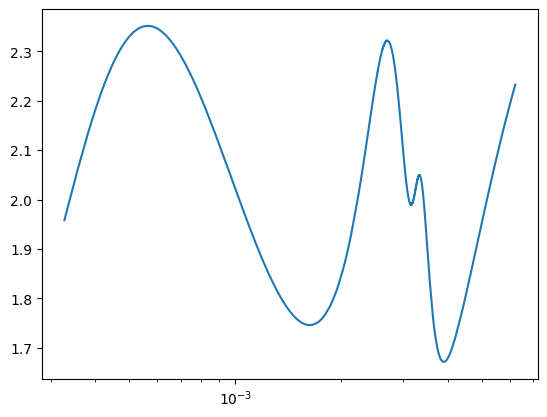

In [26]:
plt.semilogx(df['Frequency'], sn / df['SXX'])

In [4]:
from eryn.backends import HDFBackend

In [6]:
chain = hbackend.get_chain(temp_index=0)

In [7]:
s_oms, s_acc = chain['psd'][-1, 0, 0][:2]

In [78]:
def make_get_snr():
    gb = gbgpu.GBGPU()
    time = np.arange(0, YRSID_SI, 5.0)
    f = np.fft.rfftfreq(len(time), d=5.0)
    data = [np.zeros(len(f)), np.zeros(len(f))]
    sens_mat3 = AE1SensitivityMatrix(
        f,
        stochastic_params=(1.0 * YRSID_SI,),
        model=lisa_models.sangria,
    )
    def get_snr(params_dict):
        # name = params_dict['Name']
        amp = params_dict['Amplitude']
        f0 = params_dict['Frequency']
        fdot = params_dict['Frequency Derivative']
        fddot = 0.0
        phi0 = params_dict['Initial Phase']
        iota = params_dict['Inclination']
        psi = params_dict['Polarization']
        lam = params_dict['Ecliptic Longitude']
        beta = params_dict['Ecliptic Latitude']

        params = np.array([amp, f0, fdot, fddot, phi0, iota, psi, lam, beta])
        gb.d_d = 0.0
        gb.get_ll(params, data, sens_mat3)[0]
        return np.sqrt(np.real(gb.h_h))
    return get_snr

In [6]:
names = get_galactic_binary_names('../../data/posterior_chains/')

In [7]:
names

['LDC0029245735',
 'LDC0042406053',
 'LDC0029417019',
 'LDC0041348506',
 'LDC0072748810',
 'LDC0033857969',
 'LDC0042850901',
 'LDC0014809393',
 'LDC0025507344',
 'LDC0033468031',
 'LDC0032276200',
 'LDC0034085669',
 'LDC0043999936',
 'LDC0066191223',
 'LDC0029371745',
 'LDC0033764011',
 'LDC0035749045',
 'LDC0030949630',
 'LDC0028491503',
 'LDC0026784278',
 'LDC0027828856',
 'LDC0047538267',
 'LDC0095164141',
 'LDC0013594359',
 'LDC0078025115',
 'LDC0055459246',
 'LDC0077246965',
 'LDC0037864976',
 'LDC0017032366',
 'LDC0037942462',
 'LDC0028549834',
 'LDC0034946881',
 'LDC0037745517',
 'LDC0028340927',
 'LDC0025974639',
 'LDC0046754033',
 'LDC0032435473',
 'LDC0029135858',
 'LDC0029710075',
 'LDC0030440912',
 'LDC0053184300',
 'LDC0038043132',
 'LDC0031942420',
 'LDC0040982145',
 'LDC0092262228',
 'LDC0011578889',
 'LDC0048222140',
 'LDC0054899049',
 'LDC0025659004',
 'LDC0023237246',
 'LDC0017337657',
 'LDC0033690228',
 'LDC0032051927',
 'LDC0049602019',
 'LDC0024171231',
 'LDC00352

In [8]:

galactic = GalacticBinary.load_feather(names[0])

Loaded LDC0029245735 with 2827 samples and 1 possible injection matches.


In [10]:
galactic.posterior.Frequency.median()

np.float64(0.0029245735516226)

In [34]:
len(df)

29000000

In [35]:
frequencies = []
for i in range(len(names)):
    galactic = GalacticBinary.load_feather(names[i])
    frequencies.append(galactic.posterior['Frequency'].median())

Loaded LDC0029245735 with 2827 samples and 1 possible injection matches.
Loaded LDC0042406053 with 4831 samples and 1 possible injection matches.
Loaded LDC0029417019 with 2453 samples and 1 possible injection matches.
Loaded LDC0041348506 with 4948 samples and 1 possible injection matches.
Loaded LDC0072748810 with 4962 samples and 1 possible injection matches.
Loaded LDC0033857969 with 4636 samples and 1 possible injection matches.
Loaded LDC0042850901 with 4943 samples and 1 possible injection matches.
Loaded LDC0014809393 with 3204 samples and 2 possible injection matches.
Loaded LDC0025507344 with 2571 samples and 1 possible injection matches.
Injections file /Users/aaron/Documents/lisa/project-catalog/data/injection_matches/LDC0033468031_injections.feather not found. Using empty DataFrame.
Loaded LDC0033468031 with 2096 samples and 0 possible injection matches.
Loaded LDC0032276200 with 4983 samples and 2 possible injection matches.
Loaded LDC0034085669 with 1764 samples and 1 po

In [36]:
high_frequency_indices = np.where(np.array(frequencies) > 0.007)[0]

In [37]:
get_snr = make_get_snr()
params_dict = {}
snrs = {}
for i in high_frequency_indices:
    galactic = GalacticBinary.load_feather(names[i])
    params = galactic.posterior.median().to_dict()
    params_dict.update({i: params})
    snrs.update({i: get_snr(params)})


Loaded LDC0072748810 with 4962 samples and 1 possible injection matches.
Loaded LDC0095164141 with 4922 samples and 1 possible injection matches.
Loaded LDC0078025115 with 4565 samples and 1 possible injection matches.
Loaded LDC0077246965 with 4977 samples and 1 possible injection matches.
Loaded LDC0092262228 with 4976 samples and 1 possible injection matches.
Loaded LDC0071357986 with 4606 samples and 1 possible injection matches.
Loaded LDC0083043047 with 4995 samples and 1 possible injection matches.
Loaded LDC0075452781 with 4604 samples and 1 possible injection matches.
Loaded LDC0086246135 with 4967 samples and 1 possible injection matches.
Loaded LDC0099293911 with 4952 samples and 1 possible injection matches.
Loaded LDC0102741667 with 3185 samples and 1 possible injection matches.
Loaded LDC0089222467 with 4793 samples and 1 possible injection matches.
Loaded LDC0074934303 with 4410 samples and 1 possible injection matches.
Loaded LDC0125932289 with 4403 samples and 1 possib

In [38]:
tyson_snrs = []
mike_snrs = []
for i in high_frequency_indices:
    tyson_snrs.append(params_dict[i]['SNR'])
    mike_snrs.append(snrs[i])


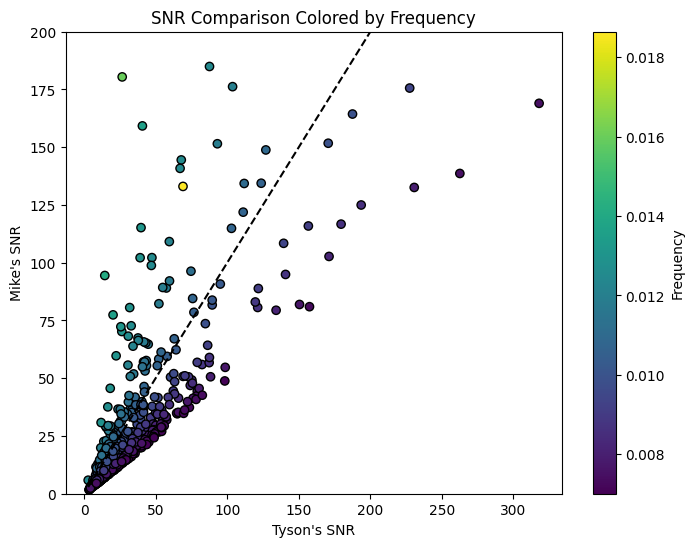

In [69]:
# Convert mike_snrs from list of one-element arrays to a flat numpy array
mike = np.array(mike_snrs).flatten()
tyson = np.array(tyson_snrs)
# Extract frequency values for the high frequency indices from the full frequencies list.
freqs = np.array(frequencies)[high_frequency_indices]

plt.figure(figsize=(8, 6))
sc = plt.scatter(tyson, mike, c=freqs, cmap='viridis', edgecolor='k')
plt.xlabel("Tyson's SNR")
plt.ylabel("Mike's SNR")
plt.title("SNR Comparison Colored by Frequency")
plt.colorbar(sc, label='Frequency')
plt.plot([tyson.min(), tyson.max()], [tyson.min(), tyson.max()], 'k--')
plt.ylim(0, 200)
plt.show()

In [73]:
np.where(np.array(frequencies) >= 0.015)

(array([  948,  2246,  4045,  6419,  6712,  7458,  9715, 10625, 11656]),)

Loaded LDC0160547469 with 4698 samples and 1 possible injection matches.


/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:846: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:847: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:849: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

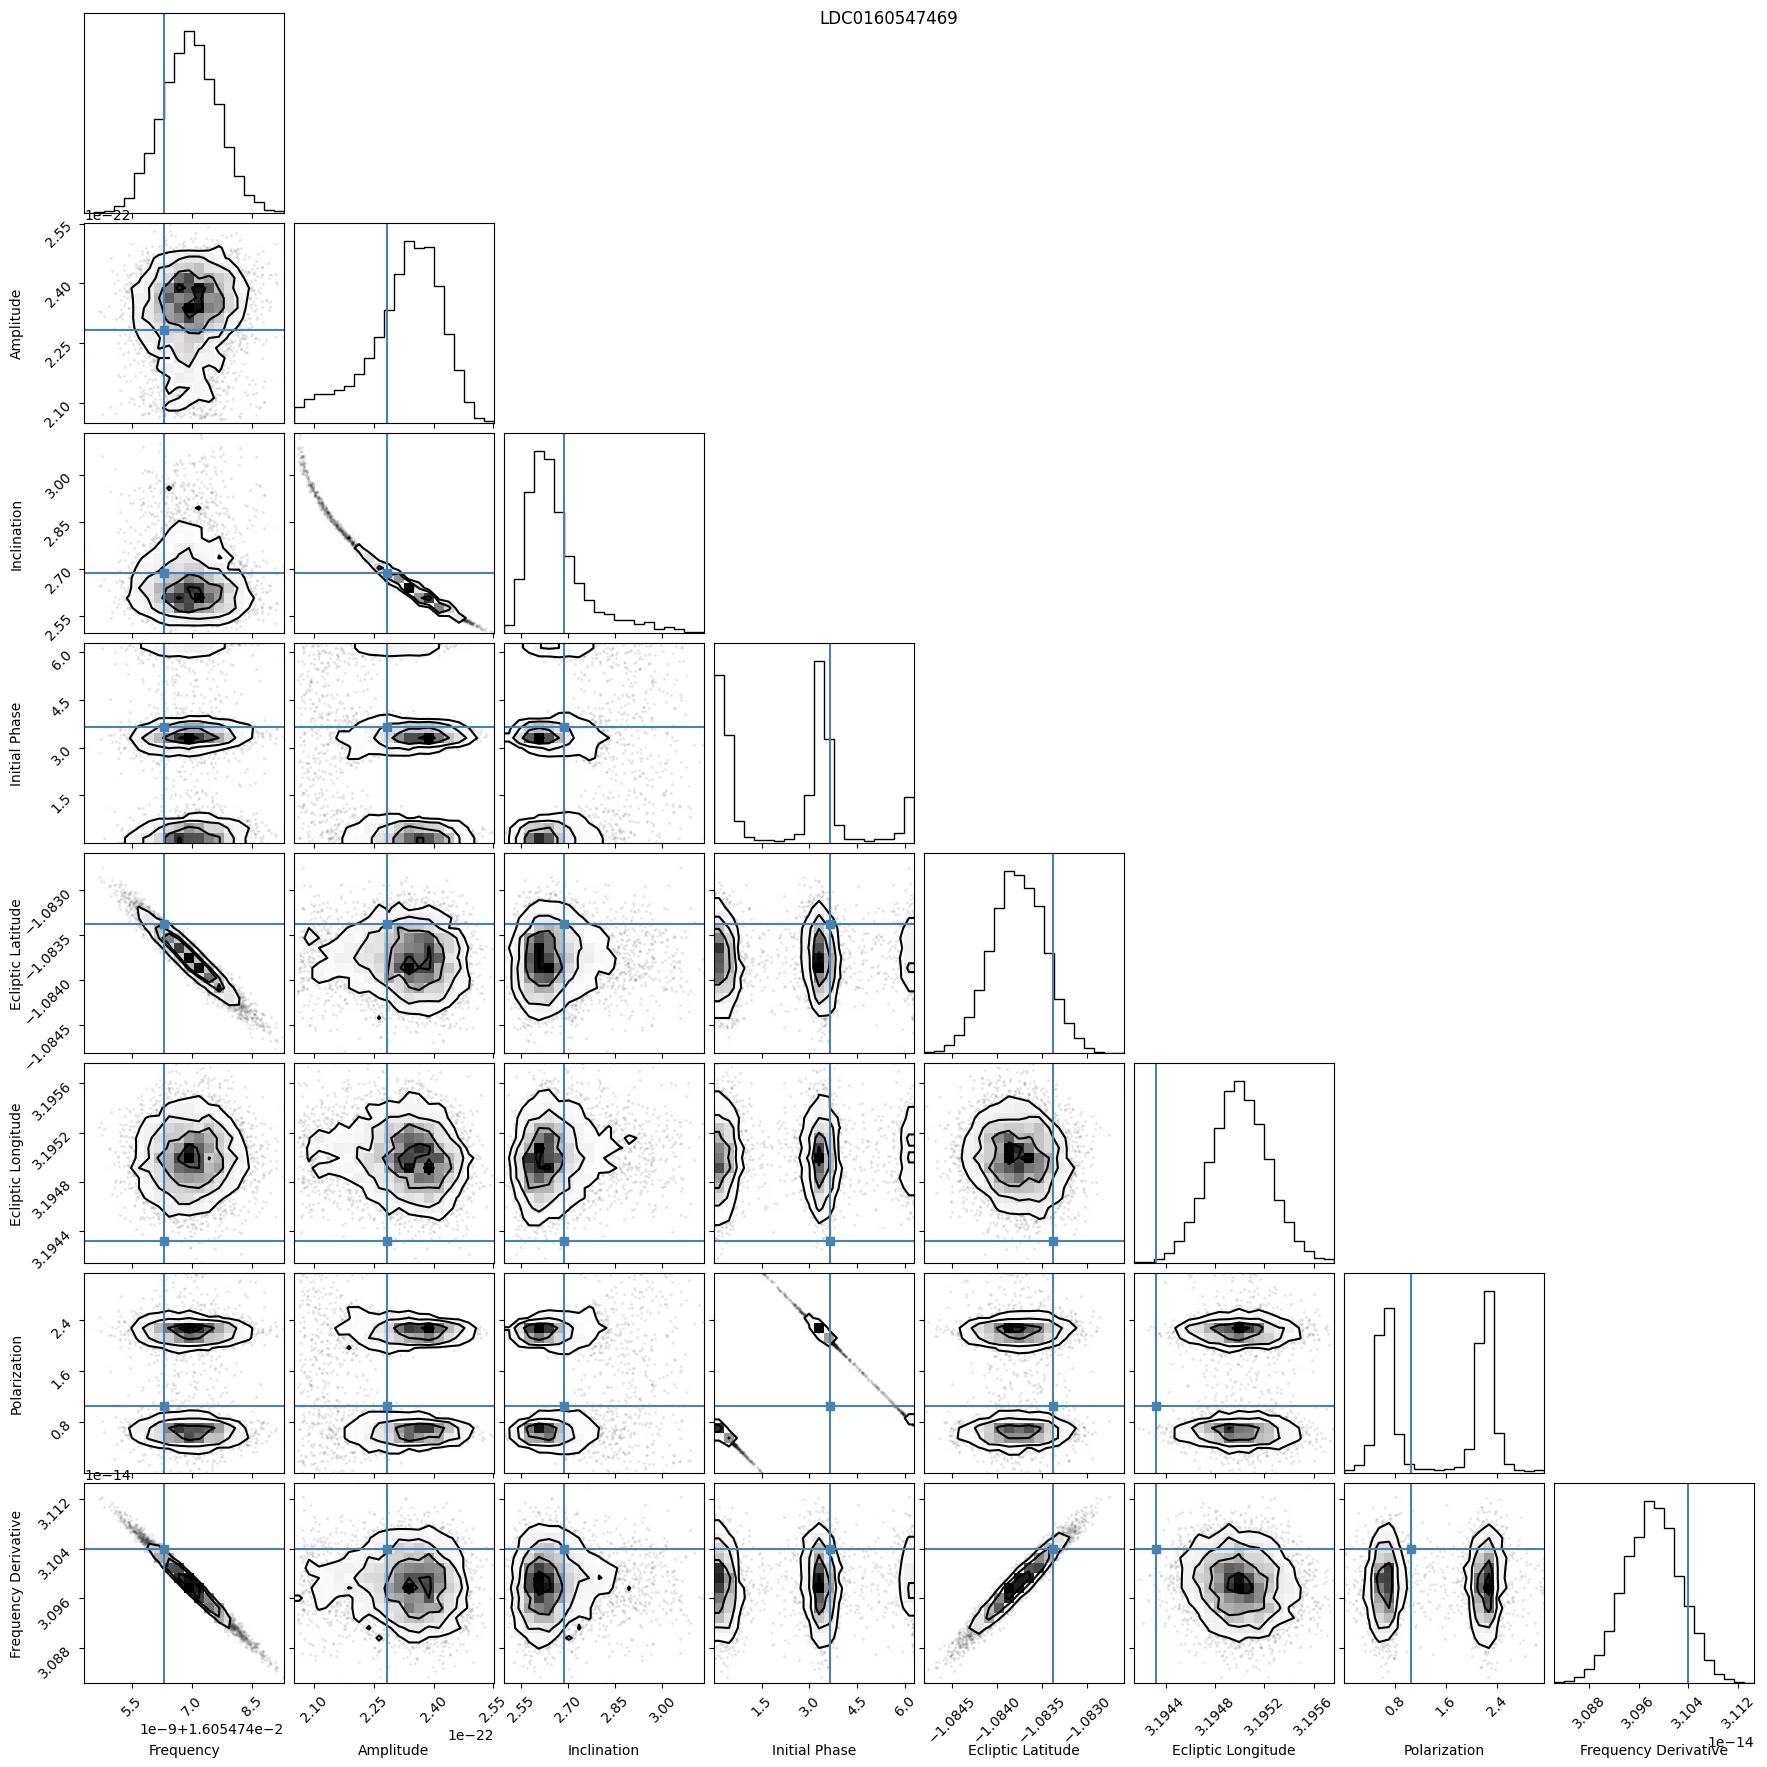

In [77]:
GalacticBinary.load_feather(names[948]).corner_plot(0);

(0.0, 200.0)

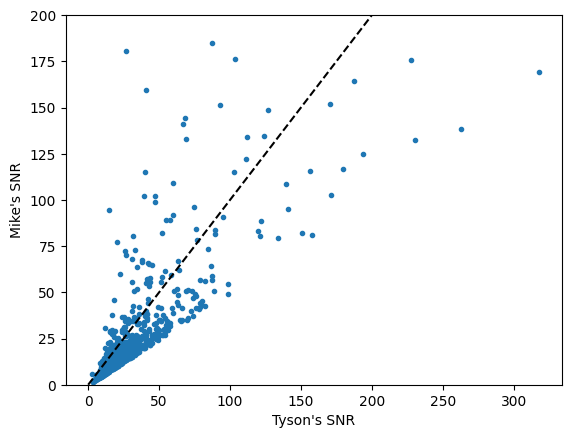

In [ ]:
plt.plot(tyson_snrs, mike_snrs, '.')
plt.plot(np.arange(300), np.arange(300), 'k--')
plt.xlabel("Tyson's SNR")
plt.ylabel("Mike's SNR")
plt.ylim(0, 200)

In [60]:
np.argmax(np.array([snrs[i] for i in high_frequency_indices]))

np.int64(893)

In [61]:
np.array([snrs[i] for i in high_frequency_indices])[893]

array([10112.88382311])

In [54]:
galactic = GalacticBinary.load_feather(names[893])

Loaded LDC0059173715 with 3896 samples and 1 possible injection matches.


/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:846: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:847: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/aaron/miniconda3/envs/catalogs/lib/python3.13/site-packages/corner/core.py:849: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

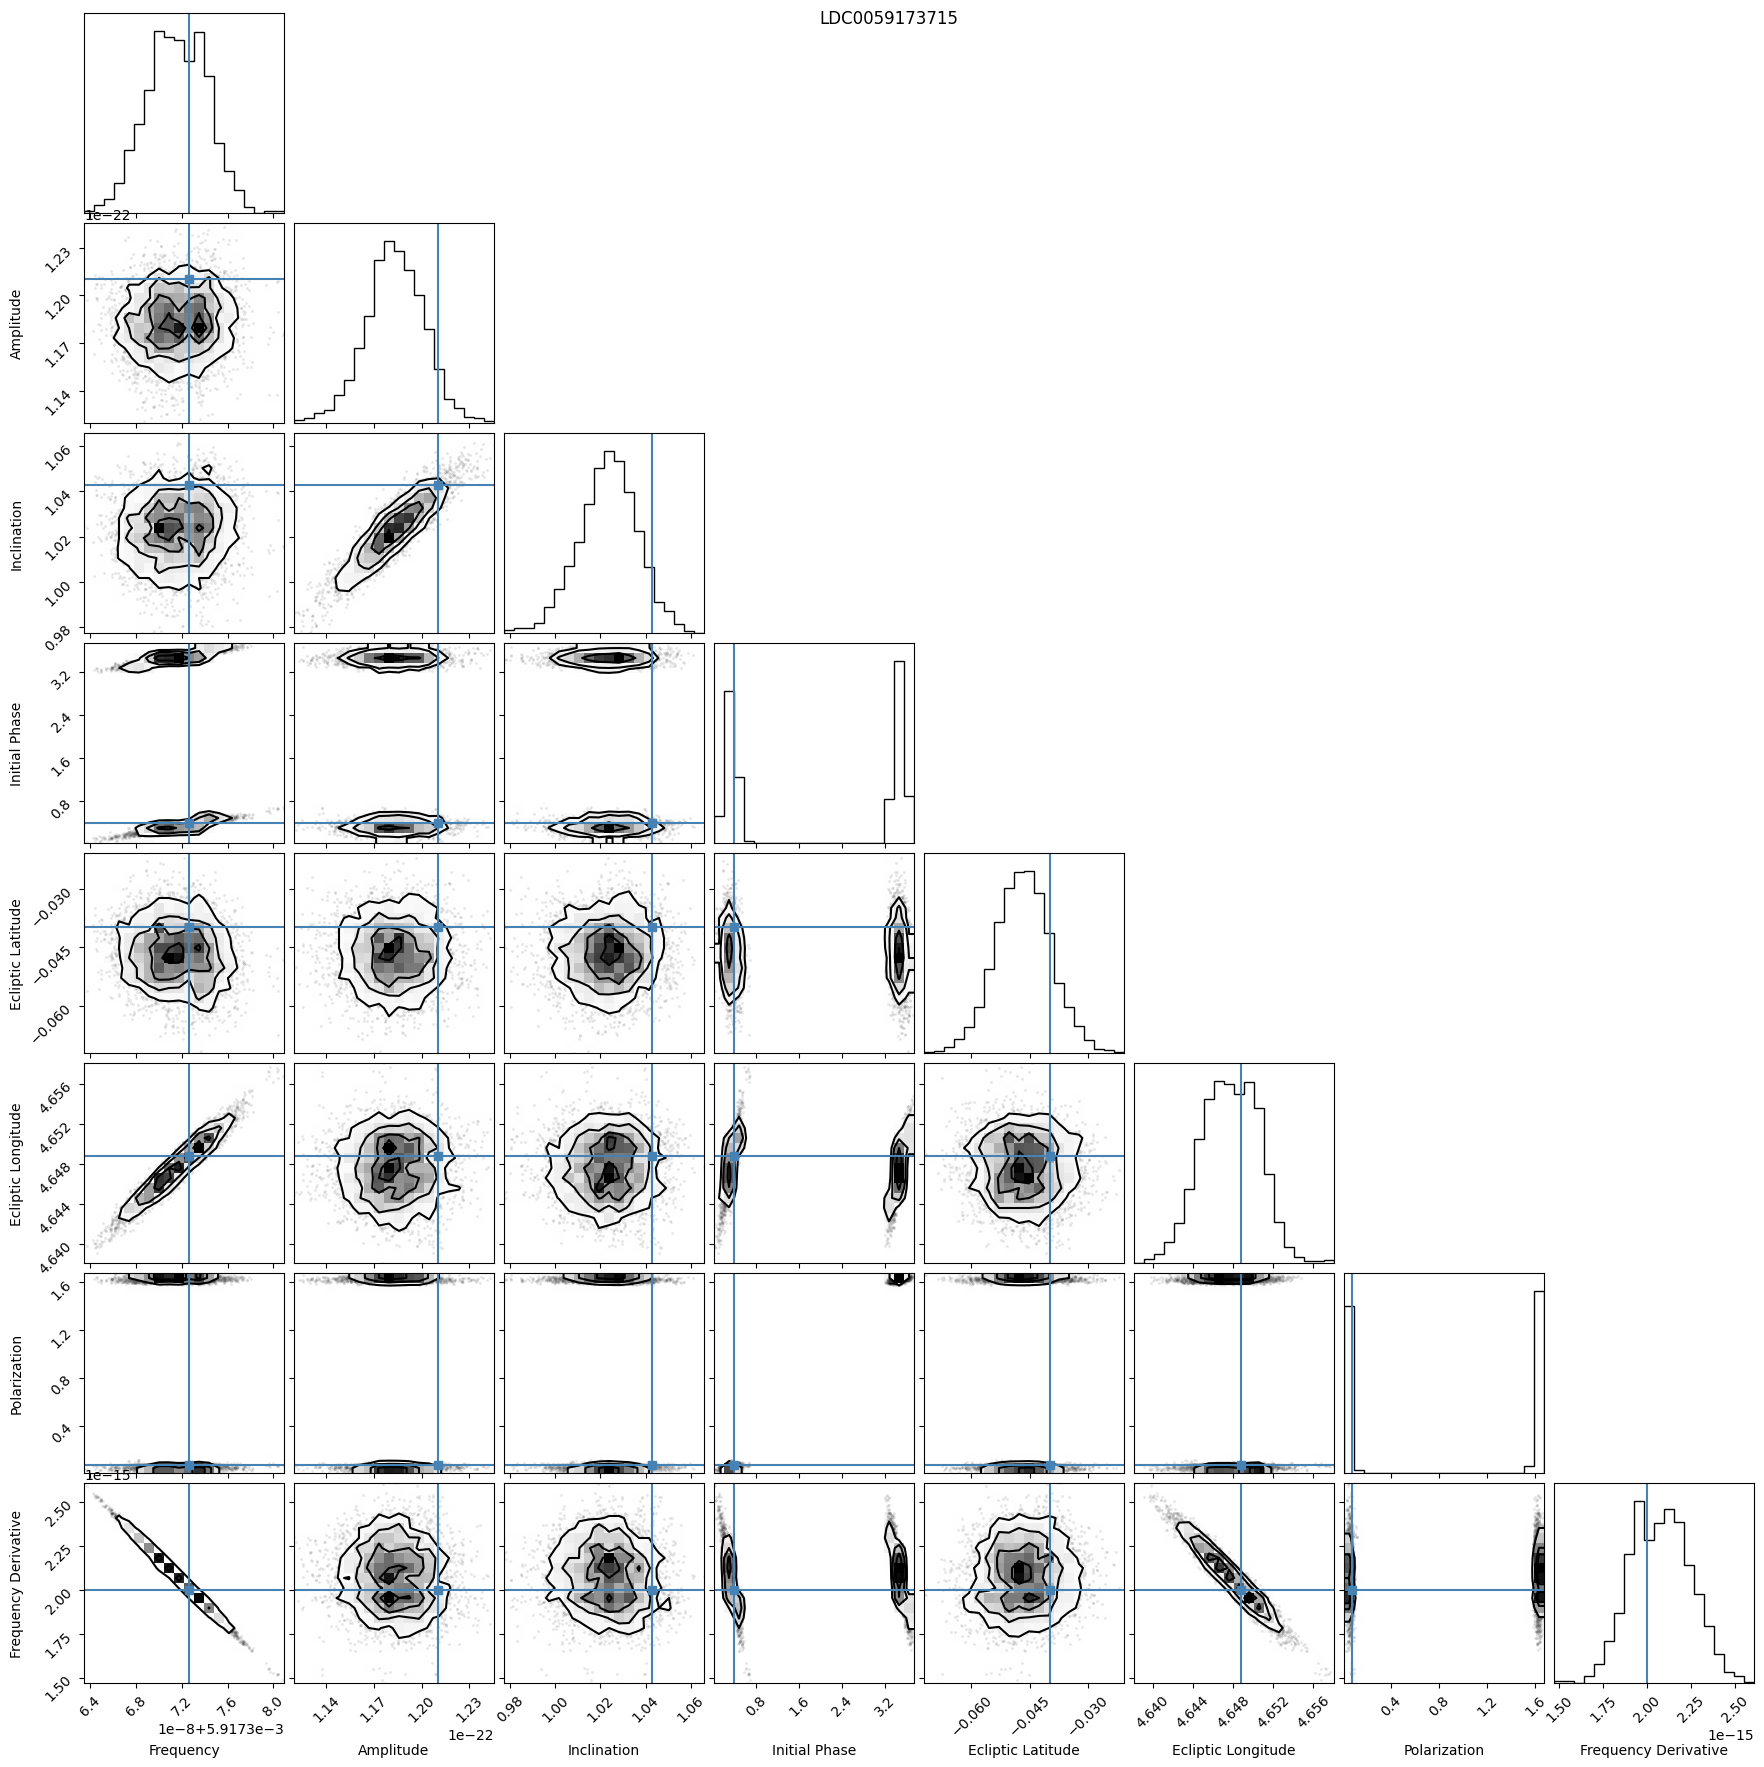

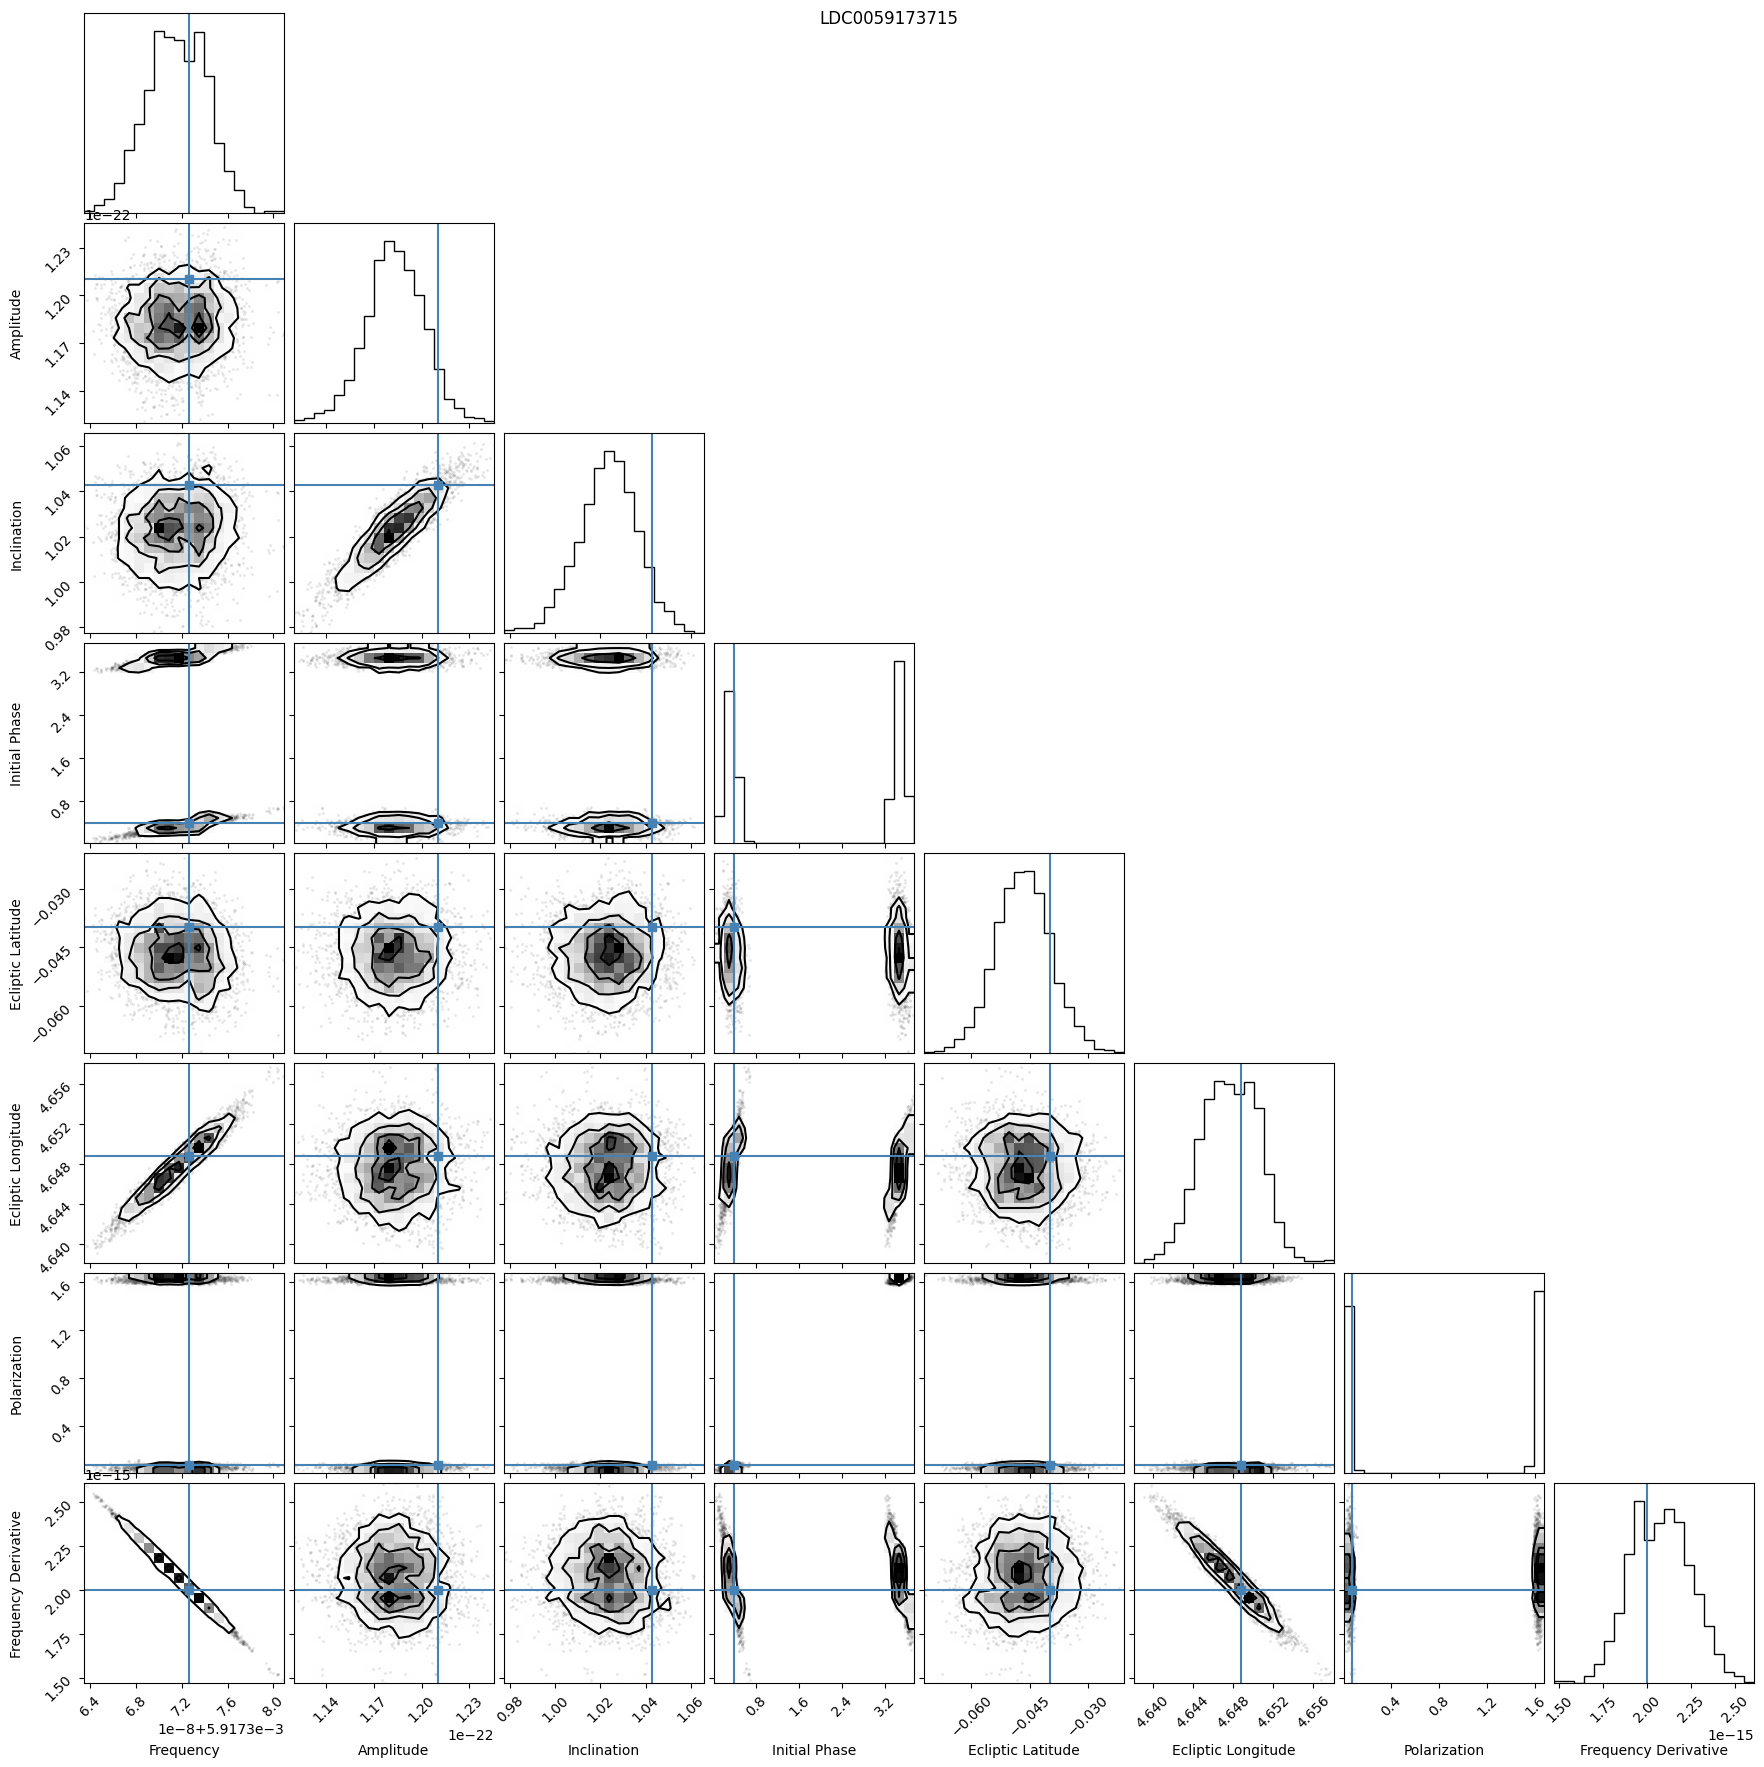

In [56]:
galactic.corner_plot(0)

In [57]:
galactic.posterior.SNR.median()

np.float64(80.90129999999999)

In [64]:
high_snr_params = galactic.posterior.median().to_dict()

In [65]:
get_snr(high_snr_params)

array([34.61549912])

In [47]:
np.where(np.array(snrs) > 10_000)

TypeError: '>' not supported between instances of 'dict' and 'int'

In [21]:
params = galactic.posterior.median().to_dict()

In [23]:
get_snr = make_get_snr()
get_snr(params)

array([5.06469989])

In [24]:
params

{'Frequency': 0.007274881053018401,
 'Frequency Derivative': 1.07480749979e-15,
 'Amplitude': 2.05661835344e-23,
 'Ecliptic Longitude': 4.78767234781,
 'coslat': 0.0903788324252,
 'cosinc': -0.2240363182265,
 'Polarization': 1.331080363805,
 'Initial Phase': 3.188184045735,
 'SNR': 9.982145,
 'entry match': 0.990256,
 'waveform measure': 0.705792,
 'Ecliptic Latitude': 0.09050232764210409,
 'Inclination': 1.7967504337124118}

In [67]:
np.pi/2 - np.arccos(0.0903788324252)

np.float64(0.09050232764197608)

In [7]:
names = []
snr_values = []
start_index = 0
for i in tqdm(range(start_index, 2)):
    params_dict = df.iloc[i].to_dict()
    name = params_dict['Name']
    snr = get_snr(params_dict)
    names.append(name)
    snr_values.append(snr)
    if len(snr_values) % 10_000 == 0:
        np.savetxt(f'./snrs/snr_values_{i // 10_000}.txt', np.c_[names, snr_values])
        names = []
        snr_values = []

  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: GBGPU.run_wave() missing 8 required positional arguments: 'f0', 'fdot', 'fddot', 'phi0', 'iota', 'psi', 'lam', and 'beta'

In [7]:
names = []
snrs = []
for i in range(2900):
    name, snr = np.loadtxt(f'/Users/aaron/Documents/lisa/project-catalog/old_files/snrs/snr_values_{i}.txt', unpack=True)
    names.append(name)
    snrs.append(snr)


In [9]:
names = np.hstack(names)
snrs = np.hstack(snrs)

In [12]:
df['SNR'] = snrs

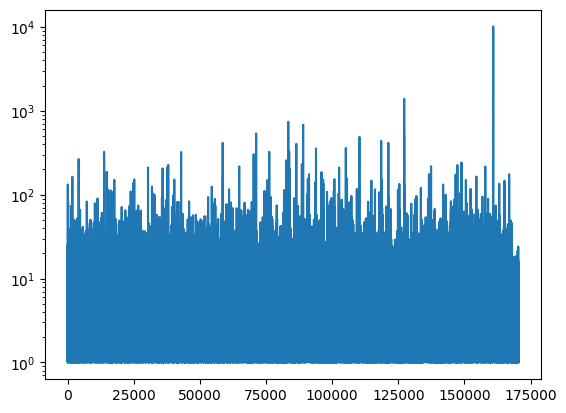

In [20]:
plt.semilogy(snrs[snrs > 1])